In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


https://medium.com/squad-engineering/one-class-classification-for-images-with-deep-features-69182fb4c9c5

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
# necessary imports
import os
import math
import pandas as pd
import numpy as np
data_path = '/content/drive/MyDrive/магистратура/realty_model/occ/'
pic_path = '/content/drive/MyDrive/магистратура/realty_model/occ/data/'

In [ ]:
import random
import cv2
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from glob import glob
from PIL import Image 
import copy

In [ ]:
#define seeds for random consistency
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
#choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = pic_path
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => /content/drive/MyDrive/магистратура/realty_model/occ/data/


In [ ]:
!pip install natsort

In [ ]:
# define image transforms for train and test
import PIL
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()])
    }

In [ ]:
import natsort
import glob
class CustomDataSet(Dataset):
    """This dataset contains pairs (image, label) as elements
    and depending on only_flats will give only_flats labels 
    or pair with flats and not_flats
    (as some models for OCC needs only samples from positive dataset)
    """
    def __init__(self, main_dir, transform, only_flats=False):
        self.main_dir = main_dir
        self.transform = transform
        tmp = glob.glob(os.path.join(main_dir, '*'))
        if only_flats:
            all_imgs = os.listdir(self.main_dir)
        else:
            all_imgs = [os.path.join(x, y) for x in tmp for y in os.listdir(x)]
        # print(all_imgs)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        label = 0 if 'not_flat' in self.total_imgs[idx] else 1
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, label

In [ ]:
train_dataset = CustomDataSet(os.path.join(root_dir, 'train'),transform=image_transforms['train'])
test_dataset = CustomDataSet(os.path.join(root_dir, 'test'),transform=image_transforms['test'])

In [ ]:
os.listdir(os.path.join(root_dir, 'train'))

['not_flat', 'flat']

In [ ]:
#loading pretrained resnet50 model
model = models.resnet50(pretrained=True,)
model = torch.jit.script(model).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
len(train_dataset)

1536

In [ ]:
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=256, num_workers=32)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=64, num_workers=32)

In [ ]:
res = []
train_labels = []
for _, x in tqdm(enumerate(train_loader)):   
    model.eval()
    with torch.no_grad():
        image_tensor, label = x
        train_labels.append(label)
        feature = model(image_tensor.to(device))
        res.append(feature.cpu().numpy())



In [ ]:
tmp = []
for i in train_labels:
    tmp.append(i.numpy())
y_train = np.concatenate(tmp, axis=0)

In [ ]:
res_np = np.concatenate(res, axis=0)
res_np.shape

(1536, 1000)

In [ ]:
res = []
test_labels = []
for _, x in tqdm(enumerate(test_loader)):   
    model.eval()
    with torch.no_grad():
        image_tensor, label = x
        test_labels.append(label)
        feature = model(image_tensor.to(device))
        res.append(feature.cpu().numpy())
test_np = np.concatenate(res, axis=0)
test_np.shape

(400, 1000)

In [ ]:
tmp = []
for i in test_labels:
    tmp.append(i.numpy())
actual = np.concatenate(tmp, axis=0)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression

In [ ]:
X_train = res_np[:][:]
y_train = y_train[:]
X_test = test_np

In [ ]:
# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)


In [ ]:
# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=64, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Explained variance percentage = 0.88


In [ ]:
gammas = [0.001, 0.002, 0.0015, 0.0018, 0.01, 0.1]
tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas,}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
scores = ['precision']
for score in scores:
    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=10,
                           scoring='%s_weighted' % score, return_train_score=True)

    clf.fit(X_train, y_train)

    resultDf = pd.DataFrame(clf.cv_results_)
    print(resultDf[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head())

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/pytho

   mean_test_score  std_test_score                              params
0         0.857503        0.057409   {'gamma': 0.001, 'kernel': 'rbf'}
2         0.856283        0.061268  {'gamma': 0.0015, 'kernel': 'rbf'}
3         0.855653        0.059611  {'gamma': 0.0018, 'kernel': 'rbf'}
1         0.855095        0.060077   {'gamma': 0.002, 'kernel': 'rbf'}
4         0.764852        0.087129    {'gamma': 0.01, 'kernel': 'rbf'}
Best parameters set found on development set:

{'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
oc_svm_preds = clf.best_estimator_.predict(X_test)

roc auc score: oc_svm_preds
0.7825
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       200
           1       0.80      0.75      0.78       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



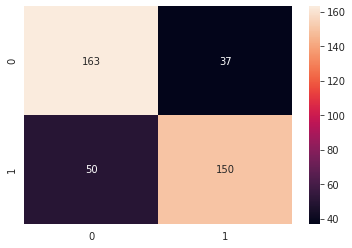

In [ ]:
print('roc auc score: oc_svm_preds')
print(roc_auc_score(actual, oc_svm_preds))
print(classification_report(actual, oc_svm_preds))
sns.heatmap(confusion_matrix(actual, oc_svm_preds),annot=True,fmt='2.0f')
plt.show()

In [ ]:
data_path = '/content/drive/MyDrive/магистратура/realty_model/model_data'

In [ ]:
ls {data_path}

In [ ]:
import pickle
# Save to file in the current working directory
pkl_filename = "occ_svm_model.pkl"
with open(os.path.join(data_path,pkl_filename), 'wb') as file:
    pickle.dump(clf.best_estimator_, file)

In [ ]:
from torch.autograd import Variable
def predict_image(image, model):
    image_tensor = image_transforms["test"](image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num=None):
    data = flat_dataset_test
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    if num is None:
        idx = indices[:]
        num = len(indices)
    else:
        idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images()
y_true_list = []
y_pred_list = []
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image, model_conv)
    y_true_list.append(int(labels[ii]))
    y_pred_list.append(index)

print(classification_report(y_true_list, y_pred_list))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [300, 500],
    'max_features': ['auto'],
    'max_depth' : [6, 8],
    'criterion' :['entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='precision_micro')
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
print(CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


In [ ]:
random_forest_preds = CV_rfc.best_estimator_.predict(X_test)

roc auc score: random_forest_preds
0.7974999999999999
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       200
           1       0.73      0.94      0.82       200

    accuracy                           0.80       400
   macro avg       0.83      0.80      0.79       400
weighted avg       0.83      0.80      0.79       400



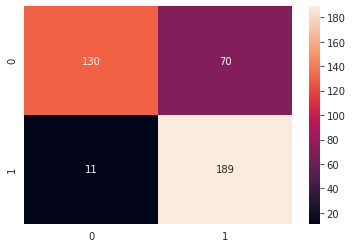

In [ ]:
print('roc auc score: random_forest_preds')
print(roc_auc_score(actual, random_forest_preds))
print(classification_report(actual, random_forest_preds))
sns.heatmap(confusion_matrix(actual, random_forest_preds),annot=True,fmt='2.0f')
plt.show()